In [1]:
using AA222

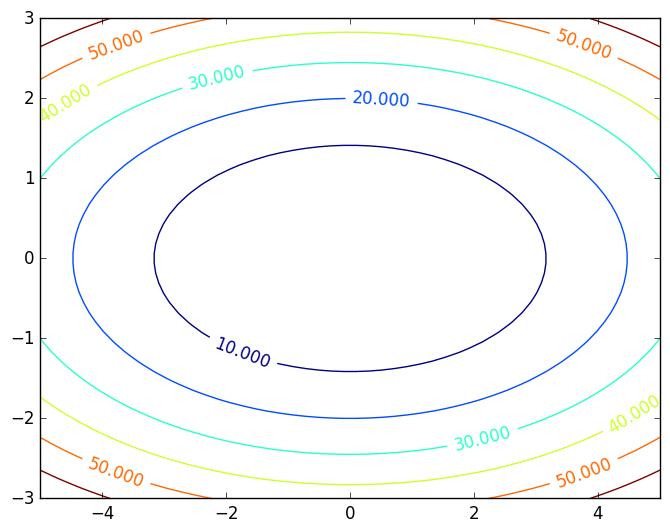

In [2]:
f(x) = x[1]^2 + 5 * x[2]^2
xdom(-5,5)
ydom(-3,3)
contour(f);

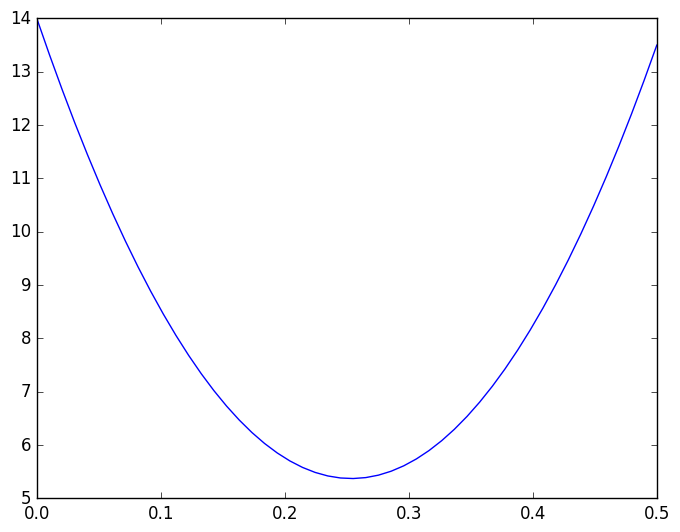

In [3]:
x0 = [3, 1]
d = [-3, -5]
xdom(0, 0.5)
plot(alpha -> f(x0 + alpha * d));

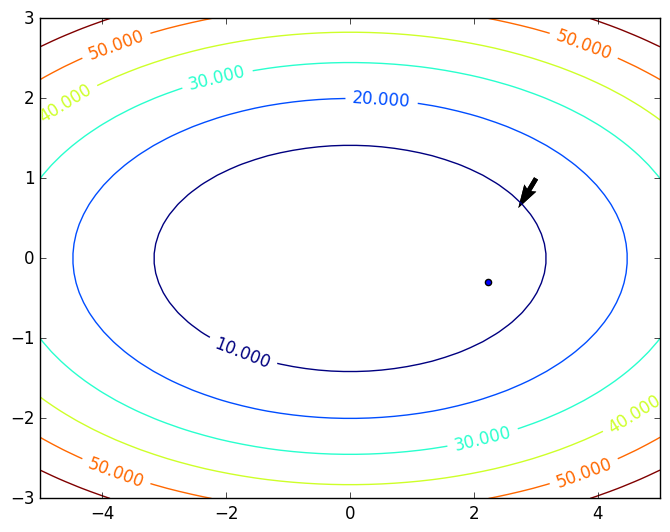

In [4]:
xdom(-5,5)
ydom(-3,3)
contour(f);
hold("on")
arrow(x0, d)
alpha = 0.26
scatter(x0 + 0.26 * d);

# Steepest Descent

In [5]:
# This stuff is magic.
using DualNumbers
# based on https://github.com/mattjj/autodiff/blob/master/forward_mode.jl
function D(f::Function)
    function Df{T <: Real}(pt::T)
        epsilon(f(Dual(pt,1)))
    end
    function Df{T <: Real}(pt::AbstractArray{T})
        vcat([epsilon(f([Dual(x,i==j) for (j,x)=enumerate(pt)])) for i=1:length(pt)]...)
    end
end

INFO: Recompiling stale cache file C:\Users\Mykel\.julia\lib\v0.4\DualNumbers.ji for module DualNumbers.


D (generic function with 1 method)

In [6]:
f(x) = x[1]*x[2]^2
D(f)([1,2])

2-element Array{Int64,1}:
 4
 4

In [7]:
# from last lecture
function bracketMinimum(f, x0 = 0, step = 1e-2, expansion = 2.0)
    x1 = x0
    f1 = f(x1)
    x2 = x1 + step
    f2 = f(x2)
    if f2 > f1
        (x1, x2) = (x2, x1)
        (f1, f2) = (f2, f1)
        step = -step;
    end
    while x1 < 1e30
        step = step * expansion
        x4 = x2 + step
        f4 = f(x4)
        if f4 > f2
            return x1 < x4 ? (x1, x4) : (x4, x1)
        end
        (x1, f1, x2, f2) = (x2, f2, x4, f4)
    end
    return x1 < x2 ? (x1, x2) : (x2, x1)
end   
function goldenSectionSearch(f, x1, x4, n)
    al = (sqrt(5) - 1) / 2
    x3 = al * x4 + (1 - al) * x1
    f3 = f(x3)
    for i = 1 : n - 1
        x2 = al * x1 + (1 - al) * x4
        f2 = f(x2)
        if f2 < f3
            x4 = x3
            x3 = x2
            f3 = f2
        else
            x1 = x4
            x4 = x2
            f4 = f2
        end
    end
    return x1 < x4 ? (x1, x4) : (x4, x1)
end
function linesearch(f)
    (lo, hi) = bracketMinimum(f)
    (lo, hi) = goldenSectionSearch(f, lo, hi, 100)
    return (lo + hi) / 2
end

linesearch (generic function with 1 method)

In [8]:
function steepestDescent(f, x0, epsG = 1e-6, epsA = 1e-6, epsR = 0.1, maxSteps = 100)
    x = x0;
    for i = 1:maxSteps
        g = D(f)(x)
        if norm(g) <= epsG
            break
        end
        d = -g / norm(g)
        f1d = alpha -> f(x + alpha * d)
        alpha = linesearch(f1d)
        x = x + alpha * d;
    end
    return x
end

steepestDescent (generic function with 5 methods)

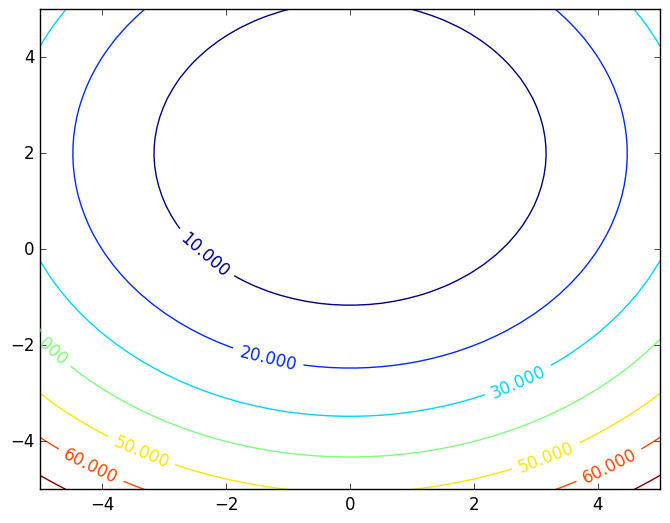

2-element Array{Float64,1}:
 0.0
 2.0

In [9]:
f(x) = x[1]^2 + (x[2] - 2)^2
xdom(-5,5)
ydom(-5,5)
contour(f)
steepestDescent(f, [0,0])

In [10]:
function steepestDescentHistory(f, x0 = [0, 0]; epsG = 1e-6, epsA = 1e-6, epsR = 0.1, maxSteps = 100)
    x = x0;
    history = x
    for i = 1:maxSteps
        g = D(f)(x)
        if norm(g) <= epsG
            break
        end
        d = -g / norm(g)
        f1d = alpha -> f(x + alpha * d)
        alpha = linesearch(f1d)
        x = x + alpha * d;
        history = [history x]
    end
    return history
end

steepestDescentHistory (generic function with 2 methods)

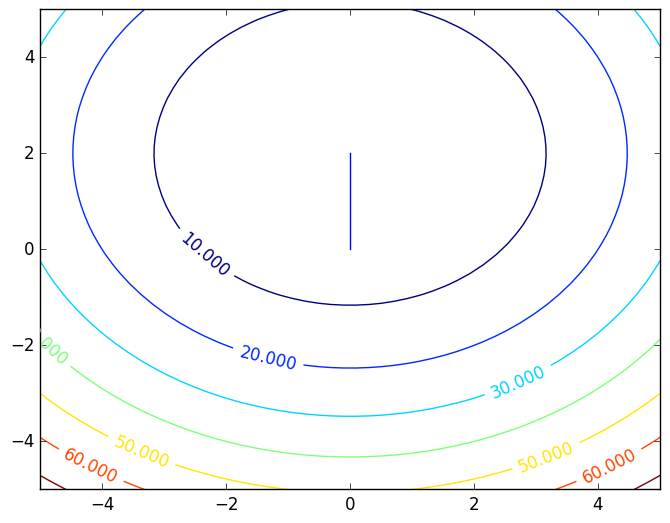

In [11]:
f(x) = x[1]^2 + (x[2] - 2)^2
contour(f)
plot(steepestDescentHistory(f));

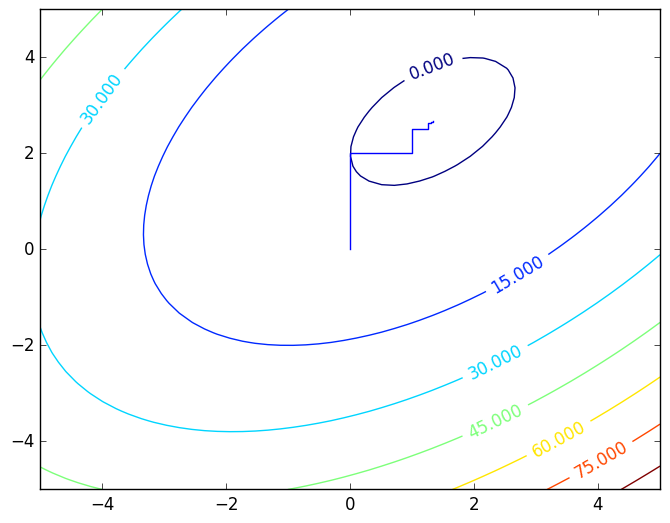

In [12]:
f(x) = x[1]^2 + (x[2] - 2)^2 - x[1]*x[2]
contour(f)
plot(steepestDescentHistory(f));

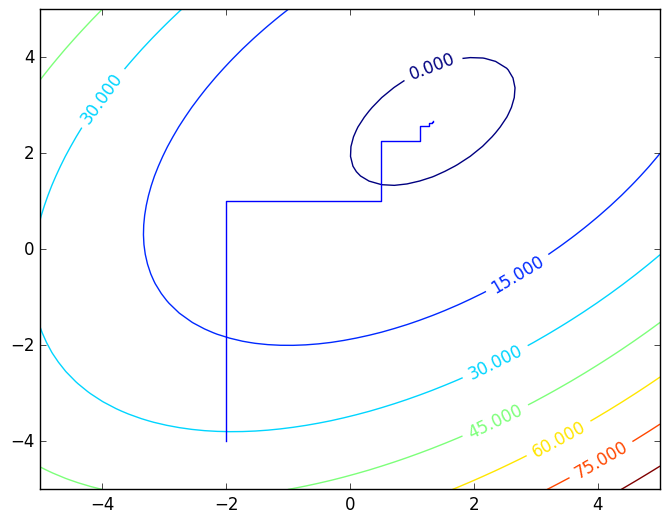

In [13]:
f(x) = x[1]^2 + (x[2] - 2)^2 - x[1]*x[2]
contour(f)
plot(steepestDescentHistory(f, [-2,-4]));

# Conjugate Gradient

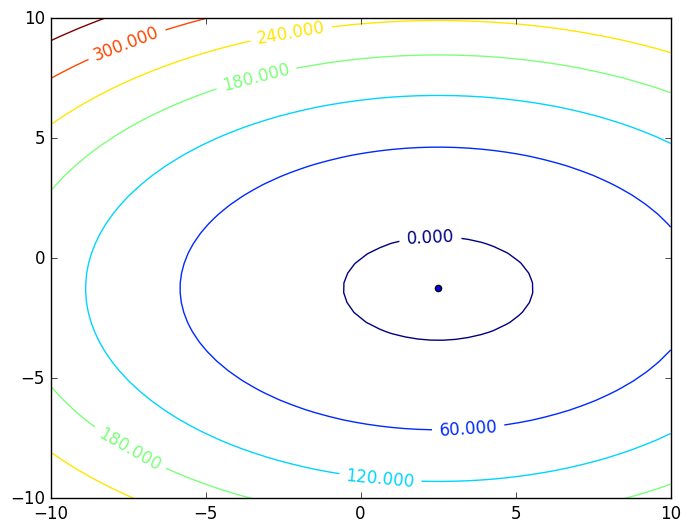

1x2 Array{Float64,2}:
 2.5  -1.25

In [14]:
A = [2 0; 0 4]
c = [-5, 5]
f(x) = (1/2) * x' * A * x + c' * x
xdom(-10, 10)
ydom(-10, 10)
contour(f)
scatter(-c' * inv(A))
-c' * inv(A)

In [15]:
function conjugateGradientDescentHistory(f, x0)
    n = length(x0) # number of dimensions
    x = x0
    history = x
    d = g = gprev = zeros(n)
    for i = 1:n
        g = A * x + c
        if i == 1
            beta = 0
        else
            beta = dot(g, (g - gprev)) / dot(gprev, gprev)
        end
        d = -g + beta * d
        alpha = dot(g, g) / dot(d, A * d)
        x = x + alpha * d
        history = [history x]
        gprev = g
    end
    return history
end

conjugateGradientDescentHistory (generic function with 1 method)

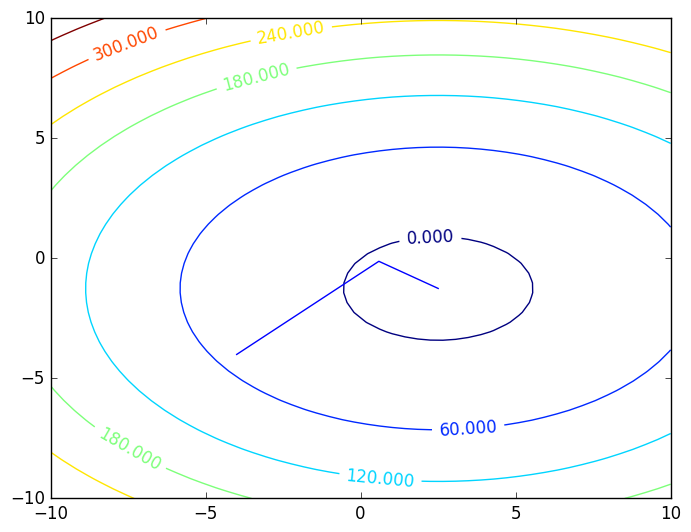

In [16]:
contour(f)
plot(conjugateGradientDescentHistory(f, [-4,-4]));

# Nonlinear Conjugate Gradient

This is often called the Fletcher-Reeves version of gradient descent.

In [17]:
function nonlinearConjugateGradientDescentHistory(f, x0, epsG = 1e-6, epsA = 1e-6, epsR = 0.1, maxSteps = 100)
    x = x0;
    history = x
    gprev = dprev = zeros(length(x0))
    for i = 1:maxSteps
        g = D(f)(x)
        if norm(g) <= epsG
            break
        end
        if i == 1
            beta = 0
        else
            beta = dot(g, g) / dot(gprev, gprev)
        end
        d = -g / norm(g) + beta * dprev
        f1d = alpha -> f(x + alpha * d)
        alpha = linesearch(f1d)
        x = x + alpha * d;
        history = [history x]
        gprev = g
        dprev = d
    end
    return history
end

nonlinearConjugateGradientDescentHistory (generic function with 5 methods)

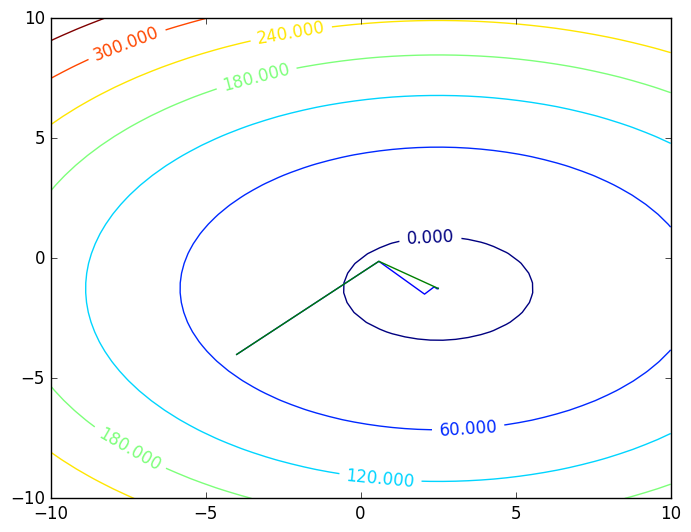

In [18]:
A = [2 0; 0 4]
c = [-5, 5]
f(x) = (1/2) * dot(x, A * x) + dot(c, x)
xdom(-10, 10)
ydom(-10, 10)
contour(f)
history = nonlinearConjugateGradientDescentHistory(f, [-4,-4])
plot(history);
history = conjugateGradientDescentHistory(f, [-4,-4])
plot(history);

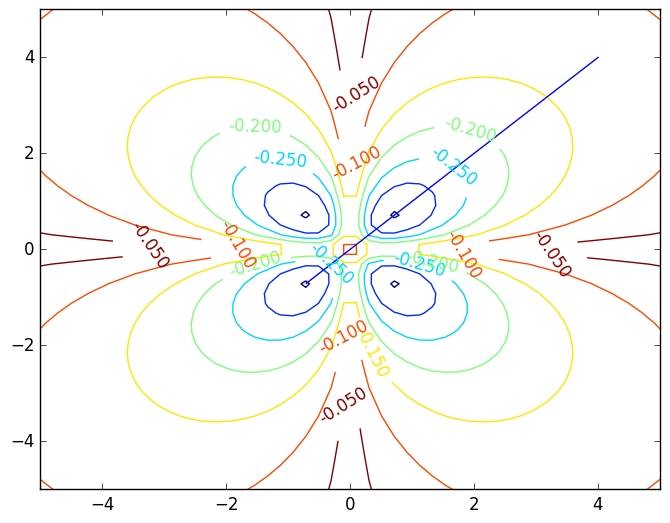

In [19]:
f(x) = -sqrt(abs(x[1] * x[2])) / (1 + x[1]^2 + x[2]^2)
xdom(-5,5)
ydom(-5,5)
contour(f)
history = nonlinearConjugateGradientDescentHistory(f, [4,4])
plot(history);